# Model Building - GRU

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
df = pd.read_excel('..\Data\gasoline_price_sentiment_pre-processed_7.xlsx', 'Sheet1')

In [3]:
df.set_index(keys='Date', drop= True, inplace= True)
df.drop('Unnamed: 0', inplace= True, axis= 1)

In [4]:
df

,price,popularity,general_sentiment,positive_outlook,happiness,bittersweet,confidence,disgust,disagreement,anxiety,...,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday,price_lag_7,price_rm,price_ewm
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,87.240684,512.0,0.725496,0.954908,1.006521,0.998807,1.002457,1.019614,1.049026,1.003928,...,0,0,1,0,0,0,0,NaN,NaN,87.240684
2010-01-02,87.240684,290.4,0.925469,0.942806,1.017355,0.996551,0.990483,1.017355,0.979214,1.003485,...,0,0,0,1,0,1,0,NaN,NaN,87.240684
2010-01-03,87.240684,230.9,0.860199,0.971601,1.008735,0.991261,0.999452,1.008735,1.061160,1.003706,...,0,0,0,0,1,1,1,NaN,NaN,87.240684
2010-01-04,87.240684,1261.1,0.959104,0.963869,1.002389,1.000800,1.002389,1.002786,1.011522,1.005566,...,0,0,0,0,0,0,0,NaN,NaN,87.240684
2010-01-05,88.983266,1902.5,0.994995,0.964214,1.004993,1.002625,0.999205,1.002099,1.008676,1.001046,...,0,0,0,0,0,0,0,NaN,NaN,87.676330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,55.956283,2051.8,0.876848,0.978322,1.004910,1.000031,1.004178,1.002470,1.013447,1.008812,...,0,1,0,0,0,0,0,57.753073,56.273227,56.460341
2018-12-28,56.043514,1519.5,0.905116,0.974309,1.008576,1.001986,1.002810,0.999680,1.000009,1.004622,...,0,0,1,0,0,0,0,56.906192,56.149987,56.356135
2018-12-29,56.043514,972.6,0.766644,0.951581,1.005672,1.003750,1.003225,1.002066,0.995369,1.002066,...,0,0,0,1,0,1,0,56.906192,56.026748,56.277979


In [5]:
df.columns

Index(['price', 'popularity', 'general_sentiment', 'positive_outlook',
       'happiness', 'bittersweet', 'confidence', 'disgust', 'disagreement',
       'anxiety', 'gloominess', 'distress', 'violent', 'unexpectedness',
       'timeliness', 'confusion', 'feelingsVsTruth', 'buyVsSell',
       'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'volatile',
       'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log',
       'month-1', 'month-2', 'month-3', 'month-4', 'month-5'

In [6]:
selected_variable_columns = ['price', 'happiness_Log', 'bittersweet_Log',
       'disgust_Log', 'disagreement_Log', 'anxiety_Log', 'gloominess_Log',
       'distress_Log', 'violent_Log', 'unexpectedness_Log', 'confusion_Log',
       'buyVsSell_sqrt', 'pricePrediction_Log', 'volatile_Log',
       'productionCommodity_Log', 'regulatory_Log', 'supplyDemandBalance_Log',
       'exploration_Log', 'accidents_Log', 'supplyDemandBalanceForecast', 
       'consumptionCommodity', 'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth',
       'timeliness', 'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'price_rm', 'price_ewm', 'month-1', 'month-2', 
       'month-3', 'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 
       'month-9', 'month-10', 'month-11', 'month-12', 'dayofweek-0',
       'dayofweek-1', 'dayofweek-2', 'dayofweek-3', 'dayofweek-4',
       'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday']

#We are taking the transformed columns and the derived features

df_subset = df[selected_variable_columns]

## Train-test split

In [7]:
tr_start = '2010-01-08'
tr_end = '2017-03-31' 
te_start = '2017-04-01'
te_end = '2018-12-31'

In [8]:
train = df_subset[tr_start : tr_end]
test = df_subset[te_start : te_end]

## Standardization of Independent Variables

In [9]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(train.iloc[:, 1:])

y = np.reshape(np.array(train.iloc[:,0]), (-1,1))

train_scaled = np.hstack((x_scaled, y))

In [10]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(test.iloc[:, 1:])

y = np.reshape(np.array(test.iloc[:,0]), (-1,1))

test_scaled = np.hstack((x_scaled, y))

In [11]:
train_scaled.shape

(2640, 53)

In [12]:
test_scaled.shape

(640, 53)

## Preparing dataset for modelling

In [13]:
#Defining a function to split multivariate sequences into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [14]:
x_train, y_train = split_sequences(train_scaled, 7)

In [15]:
print(x_train.shape)
print(y_train.shape)

(2634, 7, 52)
(2634,)


In [16]:
x_test, y_test = split_sequences(test_scaled, 7)

In [17]:
print(x_test.shape)
print(y_test.shape)

(634, 7, 52)
(634,)


## Model-building

### Setting seed

In [18]:
#Set seed to ensure reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

#Setting seed value as 7
set_seed(7)

### Baseline model (GRU)

In [23]:
base_GRU = Sequential()

base_GRU.add(GRU(units = 16, activation = 'relu', input_shape = (7, 52), return_sequences = True))
base_GRU.add(GRU(units = 8, activation = 'relu', return_sequences = False))
base_GRU.add(Dense(units = 1, activation='linear'))

base_GRU.compile(optimizer = 'adam', loss = 'mse')
base_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 7, 16)             3360      
                                                                 
 gru_3 (GRU)                 (None, 8)                 624       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,993
Trainable params: 3,993
Non-trainable params: 0
_________________________________________________________________


In [24]:
base_GRU.fit(x_train, y_train, epochs = 100, validation_split=0.2)

Epoch 1/100
66/66 [==============================] - 2s 8ms/step - loss: 11805.1914 - val_loss: 3355.9192
Epoch 2/100
66/66 [==============================] - 0s 5ms/step - loss: 7402.8311 - val_loss: 1048.7837
Epoch 3/100
66/66 [==============================] - 0s 5ms/step - loss: 511.9886 - val_loss: 257.7616
Epoch 4/100
66/66 [==============================] - 0s 4ms/step - loss: 182.2316 - val_loss: 184.0803
Epoch 5/100
66/66 [==============================] - 0s 4ms/step - loss: 119.5918 - val_loss: 158.6257
Epoch 6/100
66/66 [==============================] - 0s 4ms/step - loss: 88.7112 - val_loss: 141.2041
Epoch 7/100
66/66 [==============================] - 0s 5ms/step - loss: 71.6951 - val_loss: 125.6191
Epoch 8/100
66/66 [==============================] - 0s 5ms/step - loss: 58.2869 - val_loss: 106.7767
Epoch 9/100
66/66 [==============================] - 0s 5ms/step - loss: 48.8925 - val_loss: 101.1305
Epoch 10/100
66/66 [==============================] - 0s 5ms/step - loss

In [25]:
pred_GRU = base_GRU.predict(x_train)
print('The MSE for the baseline GRU model is: {0:.2f}'.format(mean_squared_error(y_train, pred_GRU)))
print('The RMSE for the baseline GRU model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_GRU))))
print('The MAPE for the baseline GRU model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_GRU)))

83/83 [==============================] - 0s 1ms/step
The MSE for the baseline GRU model is: 6.65
The RMSE for the baseline GRU model is: 2.58
The MAPE for the baseline GRU model is 0.02


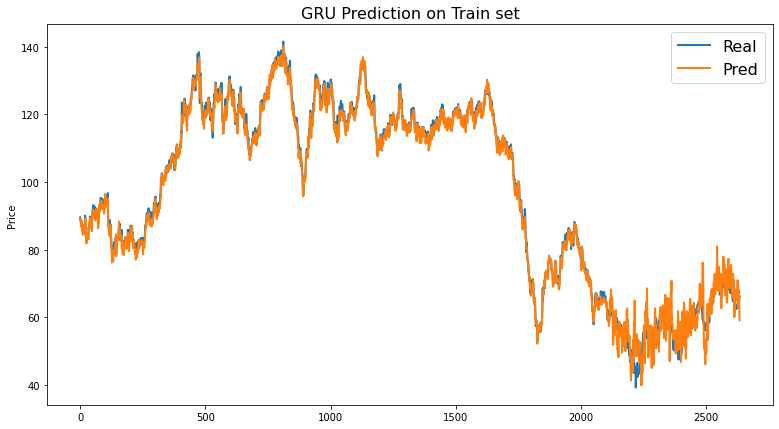

In [26]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('GRU Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [27]:
pred_GRU = base_GRU.predict(x_test)
print('The MSE for the baseline GRU model is: {0:.2f}'.format(mean_squared_error(y_test, pred_GRU)))
print('The RMSE for the baseline GRU model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_GRU))))
print('The MAPE for the baseline GRU model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_GRU)))

20/20 [==============================] - 0s 1ms/step
The MSE for the baseline GRU model is: 792.93
The RMSE for the baseline GRU model is: 28.16
The MAPE for the baseline GRU model is 0.29


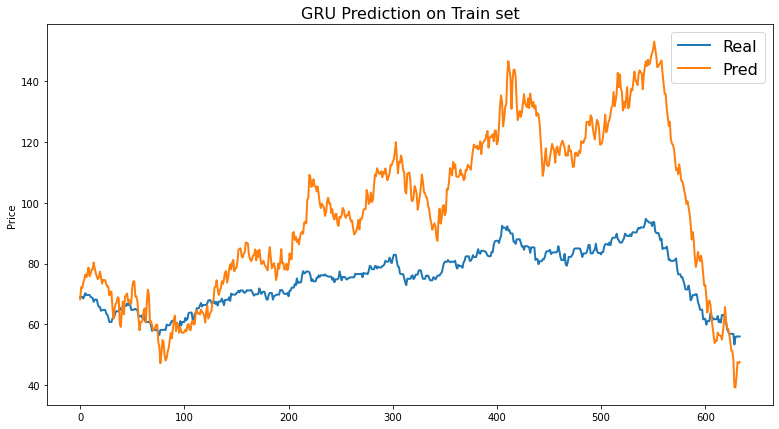

In [28]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('GRU Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Hyperparameter Tuning (Grid Search)

#### Epochs and Batch Size

In [29]:
def create_GRU(optimizer = 'adam'):
    model = Sequential()

    model.add(GRU(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
    model.add(GRU(units = 8, activation = 'relu', return_sequences = False))
    model.add(Dense(units = 1, activation='linear'))

    model.compile(optimizer = optimizer, loss = 'mse')

    return(model)

In [31]:
base_LSTM = KerasRegressor(build_fn=create_GRU, verbose=1)

#Defining the grid search parameters
batch_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#epochs = [10, 30, 50, 70, 90]

#Grid search
param_grid = dict(batch_size=batch_size, optimizer = optimizer)
grid = GridSearchCV(estimator=base_LSTM, param_grid=param_grid, n_jobs=-1, cv=5)
epoch_batch_size_result = grid.fit(x_train, y_train)

c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan   -654.00736389 -10136.26767578 -10243.00859375
   -332.07438965  -7311.11708984   -313.97101135             nan
  -1727.91983032 -10056.88325195 -10179.88027344  -3575.26640625
  -9704.26259766  -1262.86356201             nan  -5535.39526367
 -10096.67338867 -10197.79389648  -8404.39521484  -9969.94443359
  -7844.97368164             nan  -9512.59726562  -9969.95507812
 -10095.61162109  -9458.83193359  -9904.35351562  -8895.11469727
             nan  -9482.58974609 -10096.1706543  -10176.65

264/264 [==============================] - 4s 7ms/step - loss: 2821.2478


In [32]:
#Define a function to generate grid search results
def generate_grid_search_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
#Displaying grid search results (epochs and batch size)
generate_grid_search_results(epoch_batch_size_result)

Best: -313.971011 using {'batch_size': 10, 'optimizer': 'Nadam'}
nan (nan) with: {'batch_size': 10, 'optimizer': 'SGD'}
-654.007364 (649.614334) with: {'batch_size': 10, 'optimizer': 'RMSprop'}
-10136.267676 (4272.117334) with: {'batch_size': 10, 'optimizer': 'Adagrad'}
-10243.008594 (4329.483228) with: {'batch_size': 10, 'optimizer': 'Adadelta'}
-332.074390 (175.031154) with: {'batch_size': 10, 'optimizer': 'Adam'}
-7311.117090 (5873.775134) with: {'batch_size': 10, 'optimizer': 'Adamax'}
-313.971011 (61.108448) with: {'batch_size': 10, 'optimizer': 'Nadam'}
nan (nan) with: {'batch_size': 20, 'optimizer': 'SGD'}
-1727.919830 (1202.673666) with: {'batch_size': 20, 'optimizer': 'RMSprop'}
-10056.883252 (4223.548740) with: {'batch_size': 20, 'optimizer': 'Adagrad'}
-10179.880273 (4283.426075) with: {'batch_size': 20, 'optimizer': 'Adadelta'}
-3575.266406 (2131.539434) with: {'batch_size': 20, 'optimizer': 'Adam'}
-9704.262598 (4313.294561) with: {'batch_size': 20, 'optimizer': 'Adamax'}


#### Optimizer

In [35]:
base_LSTM = KerasRegressor(build_fn=create_GRU, verbose=0)

#Define the grid search parameters
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [10, 30, 50, 70, 90]

param_grid = dict(optimizer= ['Nadam'], batch_size = [10], epochs = epochs)

#Grid search
grid = GridSearchCV(estimator=base_LSTM, param_grid=param_grid, n_jobs=-1, cv=5)
optimizer_result = grid.fit(x_train, y_train)

c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [36]:
generate_grid_search_results(optimizer_result)

Best: -26.461346 using {'batch_size': 10, 'epochs': 90, 'optimizer': 'Nadam'}
-37.546034 (4.293672) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Nadam'}
-33.755874 (15.752046) with: {'batch_size': 10, 'epochs': 30, 'optimizer': 'Nadam'}
-29.588894 (11.209696) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'Nadam'}
-27.678746 (12.527204) with: {'batch_size': 10, 'epochs': 70, 'optimizer': 'Nadam'}
-26.461346 (8.825750) with: {'batch_size': 10, 'epochs': 90, 'optimizer': 'Nadam'}


### Optimized Model (GRU)



In [30]:
opt_GRU = Sequential()

opt_GRU.add(GRU(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
opt_GRU.add(GRU(units = 8, activation = 'relu', return_sequences = False))
opt_GRU.add(Dense(units = 1, activation='linear'))

opt_GRU.compile(optimizer = 'Nadam', loss = 'mse')
opt_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 7, 16)             3360      
                                                                 
 gru_5 (GRU)                 (None, 8)                 624       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,993
Trainable params: 3,993
Non-trainable params: 0
_________________________________________________________________


In [31]:
opt_GRU.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10)

Epoch 1/90
211/211 [==============================] - 3s 5ms/step - loss: 3936.5952 - val_loss: 178.0986
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 123.5006 - val_loss: 95.9289
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 65.4729 - val_loss: 82.9528
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 45.0205 - val_loss: 60.1240
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 34.3072 - val_loss: 51.6134
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 27.4330 - val_loss: 51.1559
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 23.0831 - val_loss: 34.8588
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 19.2732 - val_loss: 47.8060
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 17.0727 - val_loss: 37.5688
Epoch 10/90
211/211 [==============================] - 1s 4ms/step - loss: 14.

In [32]:
pred_GRU = opt_GRU.predict(x_train)
print('The MSE for the optimised GRU model is: {0:.2f}'.format(mean_squared_error(y_train, pred_GRU)))
print('The RMSE for the optimised GRU model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_GRU))))
print('The MAPE for the optimised GRU model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_GRU)))

83/83 [==============================] - 0s 1ms/step
The MSE for the optimised GRU model is: 6.07
The RMSE for the optimised GRU model is: 2.46
The MAPE for the optimised GRU model is 0.02


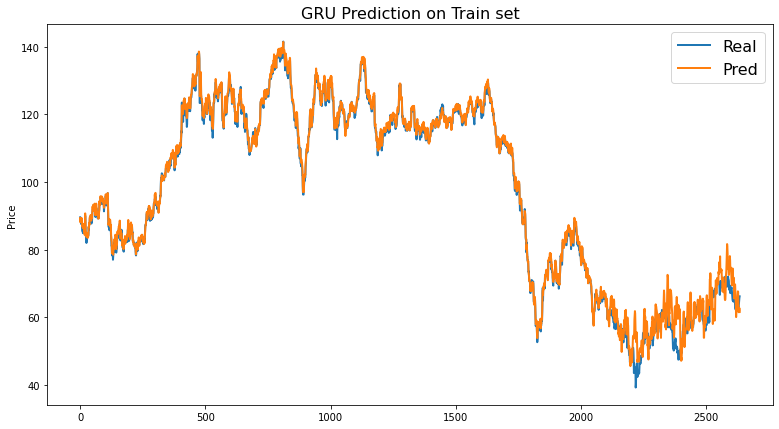

In [33]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('GRU Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [34]:
pred_GRU = opt_GRU.predict(x_test)
print('The MSE for the optimised GRU model is: {0:.2f}'.format(mean_squared_error(y_test, pred_GRU)))
print('The RMSE for the optimised GRU model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_GRU))))
print('The MAPE for the optimised GRU model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_GRU)))

20/20 [==============================] - 0s 1ms/step
The MSE for the optimised GRU model is: 854.53
The RMSE for the optimised GRU model is: 29.23
The MAPE for the optimised GRU model is 0.31


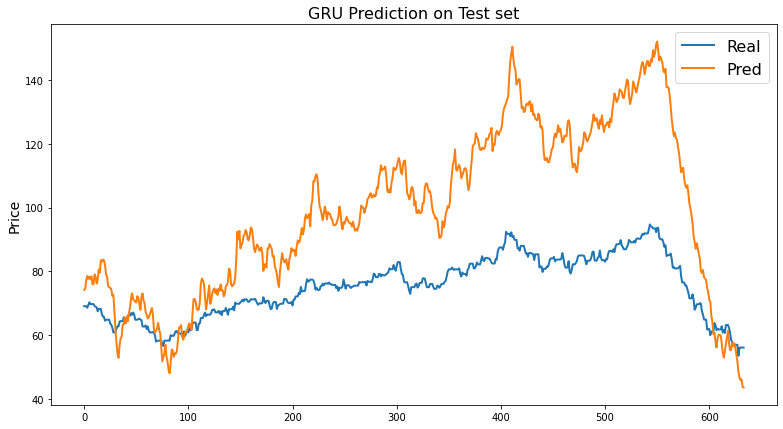

In [35]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('GRU Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Optimised Model (GRU) with Early Stopping


In [36]:
opt_GRU_es = Sequential()

opt_GRU_es.add(GRU(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
opt_GRU_es.add(GRU(units = 8, activation = 'relu', return_sequences = False))
opt_GRU_es.add(Dense(units = 1, activation='linear'))

opt_GRU_es.compile(optimizer = 'Nadam', loss = 'mse')
opt_GRU_es.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 7, 16)             3360      
                                                                 
 gru_7 (GRU)                 (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,993
Trainable params: 3,993
Non-trainable params: 0
_________________________________________________________________


In [37]:
#Defining early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1,
    verbose=2,
    mode="auto",
    restore_best_weights=True )

In [38]:
opt_GRU_es.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/90
211/211 [==============================] - 3s 5ms/step - loss: 4517.7798 - val_loss: 221.8947
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 111.0716 - val_loss: 136.6536
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 62.9874 - val_loss: 101.7145
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 44.5410 - val_loss: 77.8489
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 34.1563 - val_loss: 67.0666
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 27.8934 - val_loss: 58.7264
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 23.3313 - val_loss: 45.4395
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 19.5894 - val_loss: 45.1089
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 16.8797 - val_loss: 41.6863
Epoch 10/90
211/211 [==============================] - 1s 4ms/step - loss: 1

In [39]:
pred_GRU = opt_GRU_es.predict(x_train)
print('The MSE for the optimised GRU model with early stopping is: {0:.2f}'.format(mean_squared_error(y_train, pred_GRU)))
print('The RMSE for the optimised GRU model with early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_GRU))))
print('The MAPE for the optimised GRU model with early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_GRU)))

83/83 [==============================] - 0s 1ms/step
The MSE for the optimised GRU model with early stopping is: 10.12
The RMSE for the optimised GRU model with early stopping is: 3.18
The MAPE for the optimised GRU model with early stopping is 0.03


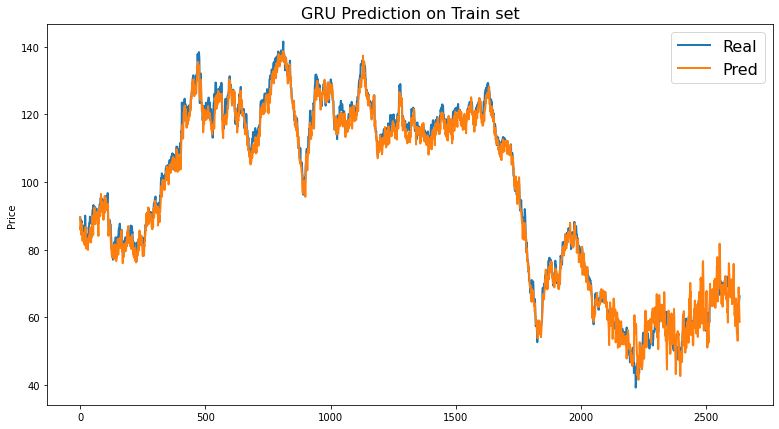

In [40]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('GRU Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [41]:
pred_GRU = opt_GRU_es.predict(x_test)
print('The MSE for the optimised GRU model with early stopping is: {0:.2f}'.format(mean_squared_error(y_test, pred_GRU)))
print('The RMSE for the optimised GRU model with early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_GRU))))
print('The MAPE for the optimised GRU model with early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_GRU)))

20/20 [==============================] - 0s 1ms/step
The MSE for the optimised GRU model with early stopping is: 749.62
The RMSE for the optimised GRU model with early stopping is: 27.38
The MAPE for the optimised GRU model with early stopping is 0.28


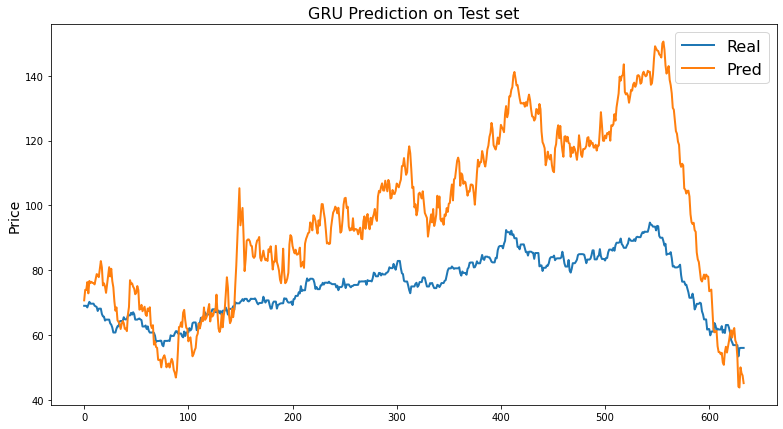

In [43]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('GRU Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### GRU model with Dropout Layers and Early Stopping 

In [44]:
dropout_GRU = Sequential()

dropout_GRU.add(GRU(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
dropout_GRU.add(Dropout(0.2))
dropout_GRU.add(GRU(units = 8, activation = 'relu', return_sequences = False))
dropout_GRU.add(Dense(units = 1, activation='linear'))

dropout_GRU.compile(optimizer = 'Nadam', loss = 'mse')
dropout_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 7, 16)             3360      
                                                                 
 dropout (Dropout)           (None, 7, 16)             0         
                                                                 
 gru_9 (GRU)                 (None, 8)                 624       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,993
Trainable params: 3,993
Non-trainable params: 0
_________________________________________________________________


In [45]:
dropout_GRU.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/90
211/211 [==============================] - 3s 5ms/step - loss: 6006.0557 - val_loss: 300.0339
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 490.8949 - val_loss: 154.9501
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 384.6766 - val_loss: 128.4119
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 307.6161 - val_loss: 106.1664
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 286.2936 - val_loss: 84.3063
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 255.4432 - val_loss: 88.6261
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 208.9951 - val_loss: 77.2331
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 192.7074 - val_loss: 74.2025
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 169.4036 - val_loss: 53.1423
Epoch 10/90
211/211 [==============================] - 1s 4ms/step -

In [46]:
pred_GRU = dropout_GRU.predict(x_train)
print('The MSE for the GRU model with dropout layers and early stopping is: {0:.2f}'.format(mean_squared_error(y_train, pred_GRU)))
print('The RMSE for the GRU model with dropout layers and early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_GRU))))
print('The MAPE for the GRU model with dropout layers and early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_GRU)))

83/83 [==============================] - 0s 1ms/step
The MSE for the GRU model with dropout layers and early stopping is: 60.89
The RMSE for the GRU model with dropout layers and early stopping is: 7.80
The MAPE for the GRU model with dropout layers and early stopping is 0.07


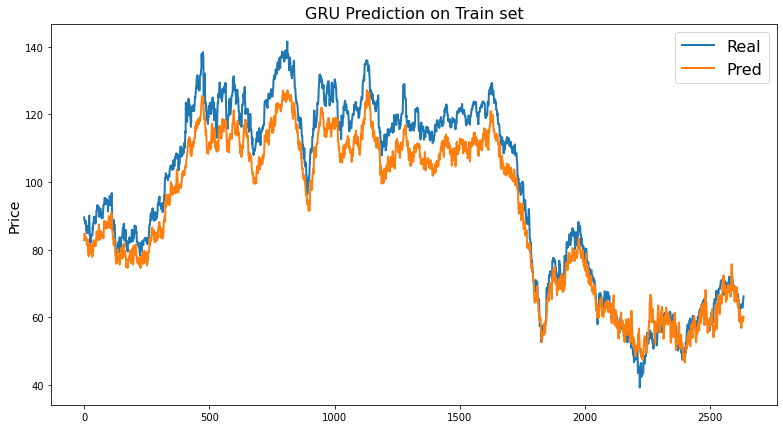

In [47]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('GRU Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [48]:
pred_GRU = dropout_GRU.predict(x_test)
print('The MSE for the GRU model with dropout layers and early stopping is: {0:.2f}'.format(mean_squared_error(y_test, pred_GRU)))
print('The RMSE for the GRU model with dropout layers and early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_GRU))))
print('The MAPE for the GRU model with dropout layers and early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_GRU)))

20/20 [==============================] - 0s 1ms/step
The MSE for the GRU model with dropout layers and early stopping is: 472.60
The RMSE for the GRU model with dropout layers and early stopping is: 21.74
The MAPE for the GRU model with dropout layers and early stopping is 0.22


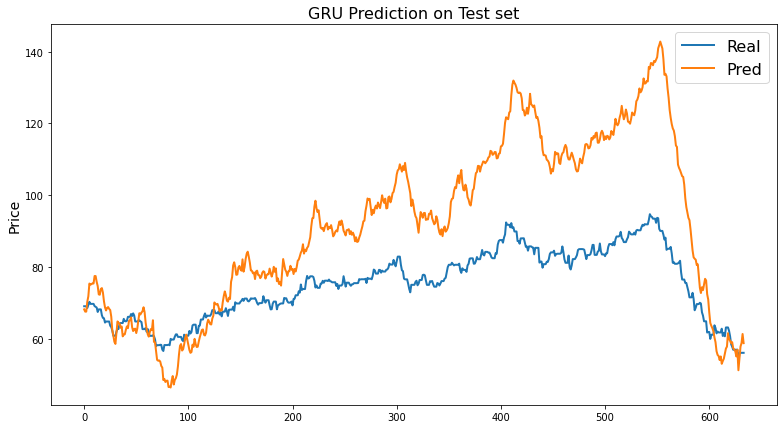

In [49]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_GRU, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('GRU Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

## Saving models

In [50]:
base_GRU.save('C:\Project Directories\DSA-9 Group 7\Models\GRU\GRU_base.h5')
opt_GRU.save('C:\Project Directories\DSA-9 Group 7\Models\GRU\GRU_optimized.h5')
opt_GRU_es.save('C:\Project Directories\DSA-9 Group 7\Models\GRU\GRU_optimized_es.h5')
dropout_GRU.save('C:\Project Directories\DSA-9 Group 7\Models\GRU\GRU_optimized_dropout_es.h5')